In [2]:
import glob
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
class dataset:
    def _get_dir_list(self, path='data/raw/*_*_0[1-4]*'):
        return glob.glob(path)

    def _get_file_list_in_dir(self, d):
        f = glob.glob(d + '/*.csv')
        f.sort()
        return f

    def _get_df_from_csv(self, f):
        is_iOS = "iphone" in f
        df = pd.read_csv(f)

        if is_iOS:
            # rename column name to integrate
            df.rename(columns={'rssi': 'remote_rssi'}, inplace=True)
            # remove unsaved parameters
            del df['magneticField.accuracy']
            del df['magneticField.field.x']
            del df['magneticField.field.y']
            del df['magneticField.field.z']
        else:
            # rename column name to integrate
            df.rename(columns={'rssi(A)': 'rssi.a'}, inplace=True)
            df.rename(columns={'rssi(B)': 'rssi.b'}, inplace=True)
            # remove unsaved parameters
            del df['temperature']
            del df['humidity']
            del df['proximity']

        # remove data while rssi is not recorded
        buf = np.where(df['rssi.a'].as_matrix() != -1)[0]
        if len(buf) == 0:
            print('x', end='')
            return None
        first_rssi_idx = buf[0]
        df = df.ix[first_rssi_idx:, :]

        # adjust the value of button pushed data 
        df.loc[df['btn_push'] == -1, 'btn_push'] = 0

        # convert -1 to NaN
        df[df == -1] = np.nan

        # interpolate NaN
        df = df.apply(pd.Series.interpolate)

        print('.', end='')

        return df

    def get(self):
        d = self._get_dir_list()
        title = [os.path.basename(_d) for _d in d]

        r = []
        for _d in d[:2]:
            print(_d)
            title = os.path.basename(_d)
            file_list = self._get_file_list_in_dir(_d)
            fname_list = [os.path.basename(_f) for _f in file_list]
            df_list = [self._get_df_from_csv(f) for f in file_list]
            print('')
            r.extend([[title, fn, df] for (fn, df) in zip(fname_list, df_list)])

        df = pd.DataFrame(r, columns=('title', 'fname', 'dataframe'))
        return df

In [4]:
ds = dataset()
data = ds.get()
data[data['title'] == '01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅']['dataframe'][0].head()

data/raw/01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅
...x..........................
data/raw/02_03_03_4F実験室_iphone_カバン_裏上_異常_まっすぐ帰宅
..............................


,date,rssi.a,rssi.b,remote_rssi,linear_accel[0],linear_accel[1],linear_accel[2],accelerometer[0],accelerometer[1],accelerometer[2],...,game_rotation[0],game_rotation[1],game_rotation[2],game_rotation[3],magnetic[0],magnetic[1],magnetic[2],pressure,light,btn_push
91,2017/04/06 14:22:23.334,-62.000000,-62.000000,-81.0,0.107452,0.013687,-0.266391,0.587601,2.197723,9.080734,...,0.096745,0.062251,0.681178,0.723023,18.890984,3.055763,-18.236160,NaN,NaN,0.0
92,2017/04/06 14:22:23.354,-66.333333,-63.428571,-81.0,0.149785,0.028881,-0.196661,0.700928,2.234436,9.088989,...,0.096946,0.062199,0.681327,0.722859,18.890984,3.055763,-18.324090,1017.940550,NaN,0.0
93,2017/04/06 14:22:23.376,-70.666667,-64.857143,-81.0,0.192119,0.044076,-0.126932,0.554733,2.217590,9.249832,...,0.097190,0.061880,0.681452,0.722737,18.709404,3.328323,-18.412018,1017.945525,NaN,0.0
94,2017/04/06 14:22:23.395,-75.000000,-66.285714,-72.0,-0.086707,0.132139,0.141152,0.397614,2.316269,9.463730,...,0.097190,0.061788,0.681132,0.723046,18.709404,3.419304,-18.587875,1017.950500,110.0,0.0
95,2017/04/06 14:22:23.415,-70.500000,-67.714286,-72.0,-0.023780,0.118709,0.021171,0.336319,2.278671,9.353012,...,0.097196,0.062068,0.681002,0.723144,18.709404,3.328514,-18.412018,1017.950500,109.5,0.0


In [8]:
def get_before_button_push(df, n):
    t = df[df['btn_push'] == 1].index
    end = t[0] if len(t) > 0 else df.index[-1] - 150
    return df.loc[(end - n + 1):end]

def search_by_title(df, s):
    return df[df['title'].str.contains(s)]

def search_by_fname(df, s):
    return df[df['fname'].str.contains(s)]

def get_data(df, title=None, fname=None, frame=[0, 0], column=None):
    if title != None: df = search_by_title(df, title)
    if fname != None: df = search_by_fname(df, fname)
    
    df_logs = df['dataframe']
    #get_before_button_push()
    return df_logs

#dfs = search_by_title(data, '.*_4F実験室_.*_カバン_裏上_.*_まっすぐ帰宅')
#df = dfs['dataframe'][30]
#df_s = get_before_button_push(df, 100)

get_data(data, '.*_4F実験室_.*_カバン_裏上_.*_まっすぐ帰宅')[0]

,date,rssi.a,rssi.b,remote_rssi,linear_accel[0],linear_accel[1],linear_accel[2],accelerometer[0],accelerometer[1],accelerometer[2],...,game_rotation[0],game_rotation[1],game_rotation[2],game_rotation[3],magnetic[0],magnetic[1],magnetic[2],pressure,light,btn_push
91,2017/04/06 14:22:23.334,-62.000000,-62.000000,-81.0,0.107452,0.013687,-0.266391,0.587601,2.197723,9.080734,...,0.096745,0.062251,0.681178,0.723023,18.890984,3.055763,-18.236160,NaN,NaN,0.0
92,2017/04/06 14:22:23.354,-66.333333,-63.428571,-81.0,0.149785,0.028881,-0.196661,0.700928,2.234436,9.088989,...,0.096946,0.062199,0.681327,0.722859,18.890984,3.055763,-18.324090,1017.940550,NaN,0.0
93,2017/04/06 14:22:23.376,-70.666667,-64.857143,-81.0,0.192119,0.044076,-0.126932,0.554733,2.217590,9.249832,...,0.097190,0.061880,0.681452,0.722737,18.709404,3.328323,-18.412018,1017.945525,NaN,0.0
94,2017/04/06 14:22:23.395,-75.000000,-66.285714,-72.0,-0.086707,0.132139,0.141152,0.397614,2.316269,9.463730,...,0.097190,0.061788,0.681132,0.723046,18.709404,3.419304,-18.587875,1017.950500,110.000000,0.0
95,2017/04/06 14:22:23.415,-70.500000,-67.714286,-72.0,-0.023780,0.118709,0.021171,0.336319,2.278671,9.353012,...,0.097196,0.062068,0.681002,0.723144,18.709404,3.328514,-18.412018,1017.950500,109.500000,0.0
96,2017/04/06 14:22:23.436,-66.000000,-69.142857,-76.0,-0.097516,0.082642,-0.027576,0.353699,2.285248,9.304230,...,0.097138,0.062275,0.680951,0.723182,18.664009,3.283024,-18.368054,1017.950500,109.000000,0.0
97,2017/04/06 14:22:23.457,-69.000000,-70.571429,-76.0,-0.028021,0.125548,-0.080337,0.384903,2.309219,9.262787,...,0.097307,0.062821,0.680940,0.723123,18.618614,3.237534,-18.324090,1017.950500,108.500000,0.0
98,2017/04/06 14:22:23.476,-72.000000,-72.000000,-70.0,-0.003606,0.096874,0.151051,0.404800,2.283081,9.519104,...,0.097399,0.062823,0.680816,0.723226,18.073875,2.783394,-19.027328,1017.940550,108.000000,0.0
99,2017/04/06 14:22:23.496,-69.333333,-69.333333,-70.0,0.037294,0.019279,0.137437,0.444199,2.185547,9.502609,...,0.097466,0.062907,0.680677,0.723341,18.255455,2.964973,-19.203186,1017.940550,107.500000,0.0
100,2017/04/06 14:22:23.517,-66.666667,-66.666667,-70.0,0.044656,-0.059004,0.087184,0.419632,2.144486,9.385407,...,0.097509,0.062935,0.680614,0.723392,18.164665,2.692413,-19.203186,1017.940550,107.000000,0.0


In [ ]:
df_s[['acceleration.x','acceleration.y','acceleration.z']].plot()
#df.loc[df.index[:-150]][['acceleration.x','acceleration.y','acceleration.z']].plot()

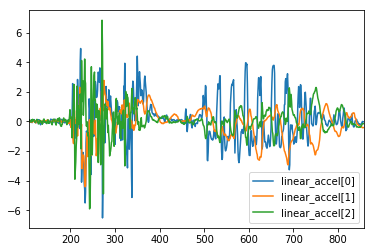

In [186]:
df[['linear_accel[0]','linear_accel[1]','linear_accel[2]']].plot()

In [109]:
_d2 = pd.DataFrame([[8,9]])
_d = pd.DataFrame([[1,2,3],[4,5,_d2]])
#_d.loc[1][2]
_d_lim = _d[[False,True]]
_d_lim[2]

KeyError: 0